## Support Vector Machines

We will create a model that classifies credit card transactions based on the given credit card dataset and
using an SVM classifier

Lets begin with the necessary imports

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.shape

(284807, 31)

The dataset seems clean without null values

Some quick sparsity and spread checks

In [5]:
print((df.to_numpy() == 0).mean())
print(df.std())

0.03240927047710974
Time      47488.145955
V1            1.958696
V2            1.651309
V3            1.516255
V4            1.415869
V5            1.380247
V6            1.332271
V7            1.237094
V8            1.194353
V9            1.098632
V10           1.088850
V11           1.020713
V12           0.999201
V13           0.995274
V14           0.958596
V15           0.915316
V16           0.876253
V17           0.849337
V18           0.838176
V19           0.814041
V20           0.770925
V21           0.734524
V22           0.725702
V23           0.624460
V24           0.605647
V25           0.521278
V26           0.482227
V27           0.403632
V28           0.330083
Amount      250.120109
Class         0.041527
dtype: float64


In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Lets now check the distribution of the dataset classes


/home/georg/miniconda3/envs/ML-Assignments/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Class')

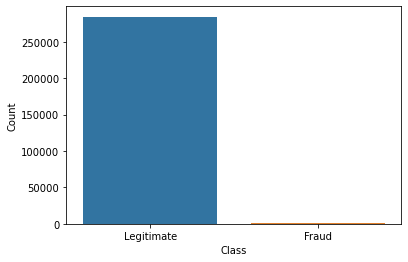

In [7]:
graph = sns.countplot(df['Class'])
graph.set_xticklabels(['Legitimate','Fraud'])
plt.ylabel("Count")
plt.xlabel("Class")

In [8]:
legitimate_count  = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])

legitimate_percentage = (legitimate_count / len(df)) * 100
fraud_percentage = (fraud_count/ len(df)) * 100

print(f"There are {legitimate_count} legitimate transactions, amounting to {legitimate_percentage:.2f}% of total transactions")
print(f"There are {fraud_count} fraudulent transactions, amounting to {fraud_percentage:.2f}% of total transactions")

There are 284315 legitimate transactions, amounting to 99.83% of total transactions
There are 492 fraudulent transactions, amounting to 0.17% of total transactions


The dataset is obviously heavily imbalanced. It is dominated by the legitimate transactions, having only 0,17% sampes
of the negative/fraudulent class. We will attempt to remedy that by resampling our data

In [9]:
y = df.pop('Class')
X = df

smote = SMOTE(sampling_strategy=0.1)
rus = RandomUnderSampler(sampling_strategy=0.5)

x_smote, y_smote = smote.fit_resample(X, y)
x_final, y_final = rus.fit_resample(x_smote, y_smote)

initial_count = Counter(y)
resampled_count = Counter(y_final)

print(f"Initial class distribution: {initial_count}")
print(f"Resampled class distribution: {resampled_count}")

x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size = 0.25, random_state = 0)

Initial class distribution: Counter({0: 284315, 1: 492})
Resampled class distribution: Counter({0: 56862, 1: 28431})


In [10]:
minMaxScaler = MinMaxScaler()
x_train = minMaxScaler.fit_transform(x_train)
x_test = minMaxScaler.transform(x_test)

Define some utility functions

In [11]:
def evaluate_model(actual, predicted, print_for_params=False, average="macro"):
    average = average
    recall_score = metrics.recall_score(actual, predicted, average=average)
    precision_score = metrics.precision_score(actual, predicted, average=average)
    f1_score = metrics.f1_score(actual, predicted, average=average)

    if print_for_params:
        average_params = ['binary', 'micro', 'macro', 'weighted']
        for param in average_params:
            recall_score = metrics.recall_score(actual, predicted, average=param)
            print(f"Precision score: {precision_score:.2f} with average parameter: {param}")

            precision_score = metrics.precision_score(actual, predicted, average=param)
            print(f"Recall score: {recall_score:.2f} with average parameter: {param}")

            f1_score = metrics.f1_score(actual, predicted, average=param)
            print(f"F1 score: {f1_score:.2f} with average parameter: {param} \n")

    accuracy_score = metrics.accuracy_score(actual, predicted)
    if print_for_params:
        print(f"Accuracy score: {accuracy_score:.2f}")

    return accuracy_score, precision_score, recall_score, f1_score

In [12]:
def pprint(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pprint(value, indent + 1)
        else:
            print('\t' * (indent + 1) + str(value))

Create our model and test it for the various parameters. Since we retained some imbalance in our dataset, we will
assign different class weights. This ofcourse could prove to be not-significant since we already remedied the imbalance
with resampling

We will assign weights inverse to the re-sampled class distribution

In [13]:
print(f"Resampled class distribution: {resampled_count}")
weights = {0:1.0, 1:2.0}

Resampled class distribution: Counter({0: 56862, 1: 28431})


In [14]:
param_list = [
    {'C': .1,  'kernel': 'poly',    'gamma': .2,  'degree': 2, 'class_weight':weights, 'probability':True, 'max_iter': 50000},
    {'C': 10,  'kernel': 'poly',    'gamma':  6,  'degree': 5, 'class_weight':weights, 'probability':True, 'max_iter': 50000},
    {'C': .1,  'kernel': 'rbf',     'gamma': .3, 'class_weight':weights, 'probability':True, 'max_iter': 10000},
    {'C': 10,  'kernel': 'rbf',     'gamma':  5, 'class_weight':weights, 'probability':True, 'max_iter': 10000},
    {'C': .1,  'kernel': 'sigmoid', 'gamma': .5, 'class_weight':weights, 'probability':True, 'max_iter': 10000},
    {'C': 10,  'kernel': 'sigmoid', 'gamma':  2, 'class_weight':weights, 'probability':True, 'max_iter': 10000},
    {'C': 100, 'kernel': 'sigmoid', 'gamma':  5, 'class_weight':weights, 'probability':True, 'max_iter': 10000}
]

In [15]:
results = []
for params in param_list:
    classifier = SVC(**params)

    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)

    results.append(evaluate_model(y_test, y_pred))

/home/georg/miniconda3/envs/ML-Assignments/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/georg/miniconda3/envs/ML-Assignments/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/georg/miniconda3/envs/ML-Assignments/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/georg/miniconda3/envs/ML-Assignments/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated e

In [17]:
for i, result in enumerate(results):
    print(f"For parameters: {param_list[i]}"),
    print(f'Accuracy: {result[0]:.3f}, Precision: {result[1]:.3f}, Recall: {result[2]:.3f}, F1: {result[3]:.3f}')
    print("\n")

For parameters: {'C': 0.1, 'kernel': 'poly', 'gamma': 0.2, 'degree': 2, 'class_weight': {0: 1.0, 1: 2.0}, 'probability': True, 'max_iter': 50000}
Accuracy: 0.975, Precision: 0.977, Recall: 0.967, F1: 0.972


For parameters: {'C': 10, 'kernel': 'poly', 'gamma': 6, 'degree': 5, 'class_weight': {0: 1.0, 1: 2.0}, 'probability': True, 'max_iter': 50000}
Accuracy: 0.865, Precision: 0.845, Recall: 0.867, F1: 0.853


For parameters: {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.3, 'class_weight': {0: 1.0, 1: 2.0}, 'probability': True, 'max_iter': 10000}
Accuracy: 0.975, Precision: 0.976, Recall: 0.967, F1: 0.971


For parameters: {'C': 10, 'kernel': 'rbf', 'gamma': 5, 'class_weight': {0: 1.0, 1: 2.0}, 'probability': True, 'max_iter': 10000}
Accuracy: 0.997, Precision: 0.997, Recall: 0.997, F1: 0.997


For parameters: {'C': 0.1, 'kernel': 'sigmoid', 'gamma': 0.5, 'class_weight': {0: 1.0, 1: 2.0}, 'probability': True, 'max_iter': 10000}
Accuracy: 0.333, Precision: 0.202, Recall: 0.499, F1: 0.250


For 